In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

students = pd.read_csv('stud_math.csv')

In [2]:
display(students.head(10))
students.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

## Блок с функциями и полезностями

In [3]:
# Создадим два списка с числовыми и номинативными значениями
object_col = students.select_dtypes(include=['object']).columns
float_col = students.select_dtypes(include=['int64', 'float64']).columns

In [4]:
#scatter plot
def scatter_plot (column):
    var = column
    data = pd.concat([students['score'], students[var]], axis=1)
    data.plot.scatter(x=var, y='score');

In [5]:
#distribution plot
def dist_plot(column, p_bin = 20):
    fig = plt.figure()
    axes = fig.add_axes([0,0,1,1])
    axes.hist(students[column], bins = p_bin, color='grey')
    axes.set_ylabel('Количество '+column)
    axes.set_xlabel(column)

In [6]:
def dist_iqr(column):
    IQR = students[column].quantile(0.75) - students[column].quantile(0.25)
    perc25 = students[column].quantile(0.25)
    perc75 = students[column].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25),
          '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR),
          "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    
    students[column].loc[students[column].between(
        perc25 - 1.5*IQR,
        perc75 + 1.5*IQR)].hist(bins = 16, label = 'IQR')
    
    plt.legend();

In [7]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=students.loc[students.loc[:, column].isin(students.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [61]:
def get_countplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.countplot(x=column,
                  data=students, 
                  ax = ax)
    ax.set_title('Countplot for ' + column)
    plt.show()

In [9]:
def get_stat_dif(column):
    cols = students.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(students.loc[students.loc[:, column] == comb[0], 'score'], 
                     students.loc[students.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

## EDA

Исследуем целевую переменную

In [10]:
students.score.describe()

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

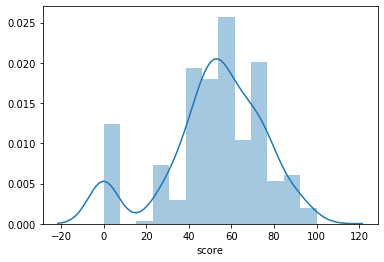

In [11]:
sns.distplot(students.score)

Можно заметить, что есть некоторое количество учеников, получивших 0 за экзамен. Исключать наблюдения, равные 0, зависит от контекста: можно ли было набрать 0 баллов или нет.

Исследуем зависимости целевой переменной от числовых признаков.

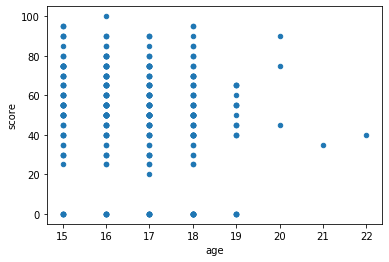

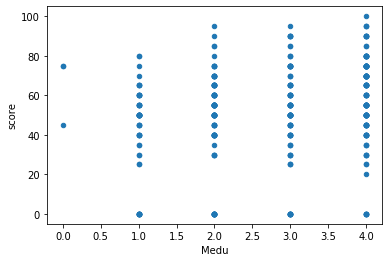

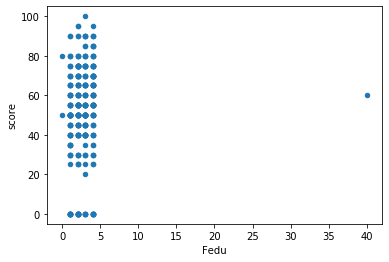

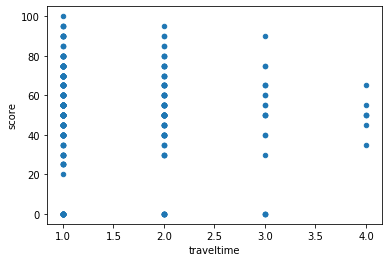

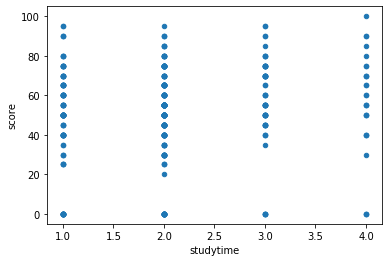

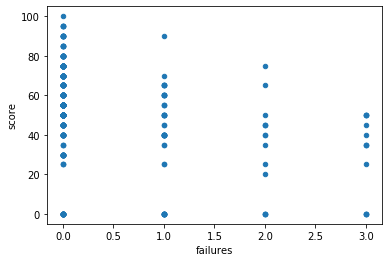

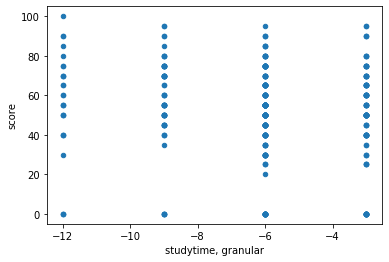

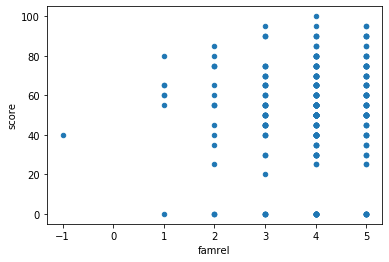

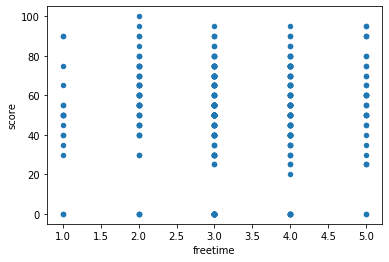

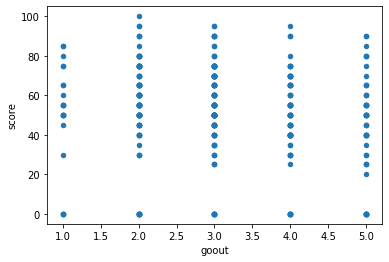

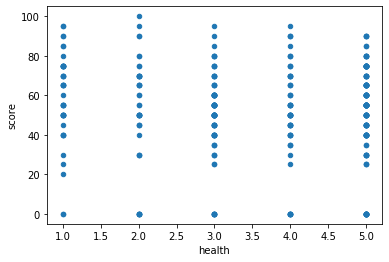

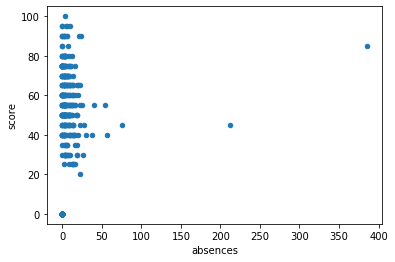

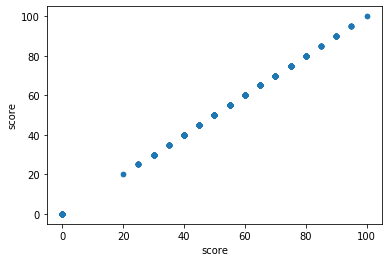

In [12]:
for col in float_col:
    scatter_plot(col)

Можно заметить кое-какие выбросы для некоторых переменных, далее рассмотрим подробнее их распределения. По данным же графикам пока сказать нечего, за исключением того, что все числовые переменные дискретны и более-менее равномерно распределены среди значений целевой переменной.

In [13]:
float_col

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'studytime, granular', 'famrel', 'freetime', 'goout', 'health',
       'absences', 'score'],
      dtype='object')

AGE (возраст ученика)

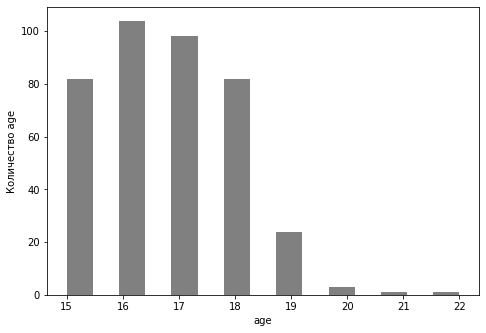

In [14]:
dist_plot('age', 15)

По графику выше можно заметить резкое уменьшение количества детей в возрасте от 20 лет. Неизвестно, может ли ученику быть более 19 лет, я бы предположила, что нет.
Далее попробуем определить выбросы по формуле межквартильного размаха.

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


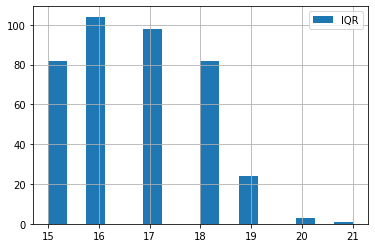

In [15]:
dist_iqr('age')

Согласно графика выше, выбросом являются записи об учениках в возрасте 22 года. Можно удалить эти записи. Также можно будет удалить записи об учениках в возрасте 20-21 год, после получения соответствуюшей информации. 

In [16]:
students = students.drop(students[students.age == 22].index)

Medu (образование отца)

In [17]:
students.Medu.describe()

count    391.000000
mean       2.749361
std        1.099461
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

In [18]:
students[students['Medu'].isnull() == True]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
92,GP,F,16,NaN,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
193,GP,M,16,R,GT3,NaN,NaN,3.0,services,services,reputation,mother,1.0,1.0,0.0,no,yes,no,yes,yes,-3.0,yes,yes,no,4.0,3.0,2.0,5.0,8.0,50.0
239,GP,M,18,U,GT3,NaN,NaN,2.0,other,services,reputation,father,1.0,2.0,1.0,no,no,no,no,yes,-6.0,no,NaN,NaN,5.0,5.0,4.0,2.0,0.0,0.0


/Users/esemenova/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/esemenova/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


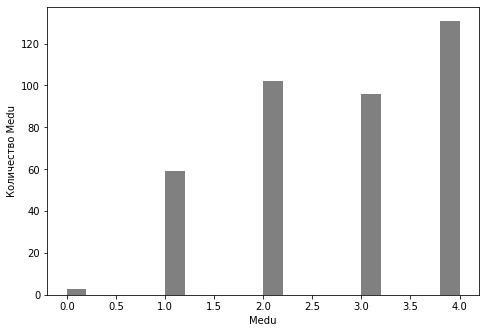

In [19]:
dist_plot('Medu')

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


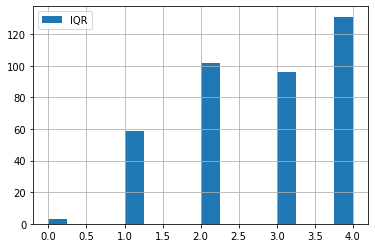

In [20]:
dist_iqr('Medu')

Мы видим отсутствующие данные по трем ученикам. Можно заполнить их медианным значением равным 3.

In [21]:
students = students.fillna({'Medu':3})

Fedu (образование матери)

In [22]:
students.Fedu.describe()

count    370.000000
mean       2.618919
std        2.230163
min        0.000000
25%        2.000000
50%        2.500000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

In [23]:
students[students['Fedu'].isnull() == True]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
21,GP,M,15,U,GT3,T,4.0,NaN,health,health,other,father,1.0,1.0,NaN,no,yes,NaN,no,yes,-3.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0
42,GP,M,15,U,GT3,T,4.0,NaN,services,teacher,course,father,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,3.0,5.0,2.0,90.0
46,GP,F,16,U,LE3,A,3.0,NaN,other,services,home,mother,1.0,2.0,0.0,no,yes,no,no,yes,-6.0,yes,yes,no,2.0,3.0,5.0,3.0,12.0,55.0
57,GP,M,15,U,GT3,T,4.0,NaN,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,no,no,3.0,2.0,2.0,5.0,4.0,75.0
58,GP,M,15,U,LE3,T,1.0,NaN,other,at_home,home,father,1.0,2.0,0.0,yes,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,2.0,5.0,2.0,45.0
67,GP,F,16,U,GT3,NaN,3.0,NaN,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
142,GP,F,15,U,GT3,T,4.0,NaN,teacher,services,course,mother,NaN,3.0,0.0,no,yes,yes,yes,yes,-9.0,NaN,yes,no,4.0,2.0,2.0,5.0,2.0,55.0
159,GP,M,16,NaN,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
161,GP,M,15,R,GT3,T,3.0,NaN,other,NaN,course,mother,2.0,2.0,2.0,yes,yes,no,no,yes,-6.0,yes,yes,yes,4.0,4.0,4.0,3.0,6.0,35.0


/Users/esemenova/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/esemenova/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


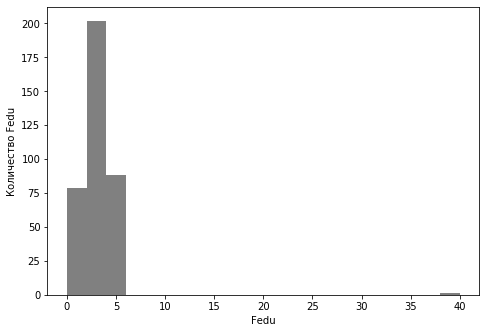

In [24]:
dist_plot('Fedu')

В случае с уровнем образования матери мы наблюдаем явный выброс со значением 40. Предположить, что должно было быть записано, мы не можем, проще удалить эту запись. 
Пропуски в количестве 24 штук можно заполнить медианным значением = 2.

In [25]:
students = students.drop(students[students.Fedu == 40].index)

In [26]:
students = students.fillna({'Fedu':2})

traveltime (время в пути до школы)

In [27]:
students.traveltime.describe()

count    365.000000
mean       1.435616
std        0.690869
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

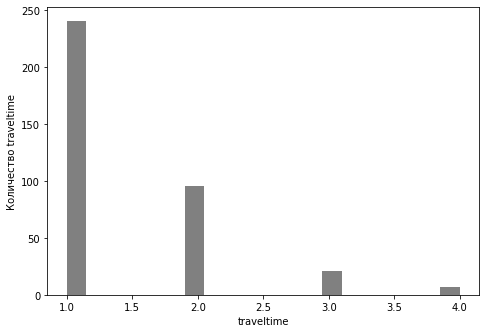

In [28]:
dist_plot('traveltime')

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


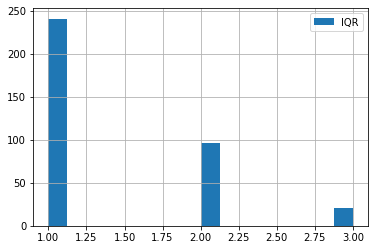

In [29]:
dist_iqr('traveltime')

Несмотря на то, что время дороги до школы, равное 4 часам, вышло за границы выбросов, удалять мы такие записи не будем.
Пропуски заполним медианным значением, равным 1.

In [30]:
students = students.fillna({'traveltime':1})

studytime (время на учёбу помимо школы в неделю)

In [31]:
students.studytime.describe()

count    386.000000
mean       2.038860
std        0.841176
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

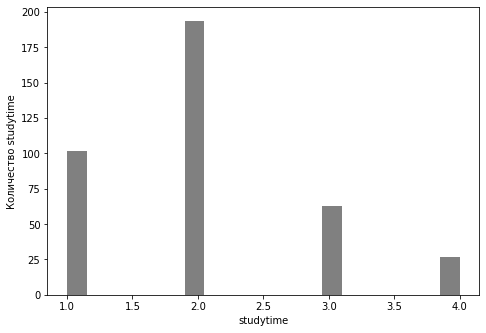

In [32]:
dist_plot('studytime')

In [33]:
#пропуски медианой
students = students.fillna({'studytime':2})

failures (количество внеучебных неудач)

In [34]:
students.failures.describe()

count    371.000000
mean       0.331536
std        0.731937
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

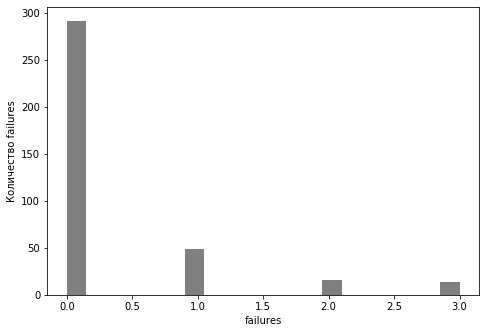

In [35]:
dist_plot('failures')

In [36]:
#Заполнение пропусков медианой
students = students.fillna({'failures':0})

Так как количество наблюдений со значением failures = 0  гораздо больше прочих, возможно, имеет смысл объединить значения 1<=n<=3, например, в 1. 

famrel (семейные отношения)

In [37]:
students.famrel.describe()

count    366.000000
mean       3.931694
std        0.926464
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

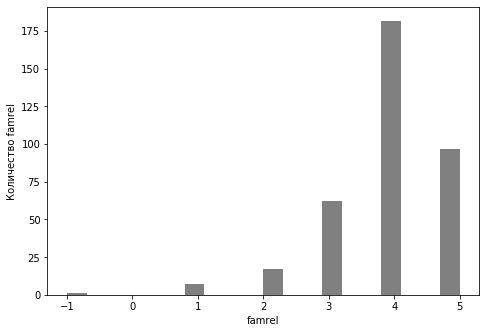

In [38]:
dist_plot('famrel')

In [39]:
#удаляем значение -1
students = students.drop(students[students.famrel == -1].index)

In [40]:
#пропуски медианой
students = students.fillna({'famrel':4})

freetime (свободное время после школы)

In [41]:
students.freetime.describe()

count    381.000000
mean       3.236220
std        0.993055
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

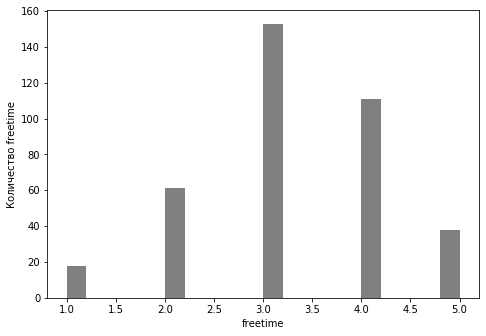

In [42]:
dist_plot('freetime')

In [43]:
#пропуски медианой
students = students.fillna({'freetime':3})

goout (проведение времени с друзьями)

In [44]:
students.goout.describe()

count    384.000000
mean       3.106771
std        1.113204
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

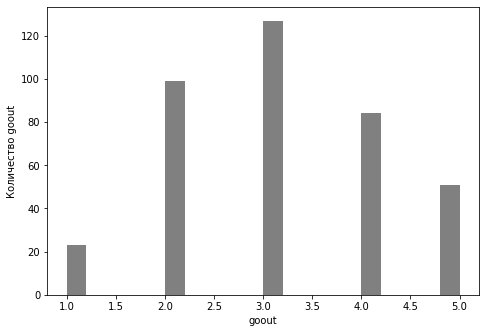

In [45]:
dist_plot('goout')

In [46]:
#пропуски медианой
students = students.fillna({'goout':3})

health (текущее состояние здоровья)

In [47]:
students.health.describe()

count    377.000000
mean       3.533156
std        1.393216
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

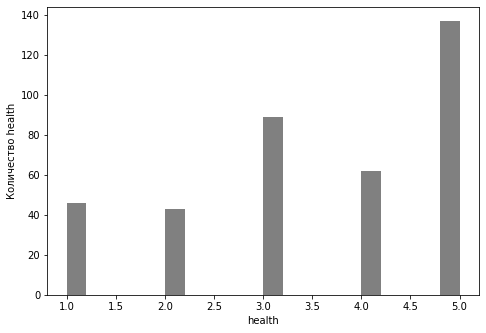

In [48]:
dist_plot('health')

In [49]:
#пропуски медианой
students = students.fillna({'health':4})

absences (количество пропущенных занятий)

In [50]:
students.absences.describe()

count    380.000000
mean       7.247368
std       23.550471
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

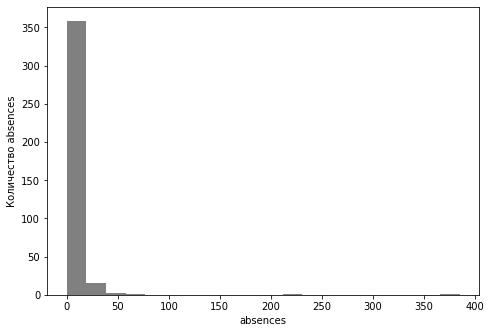

In [51]:
dist_plot('absences')

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


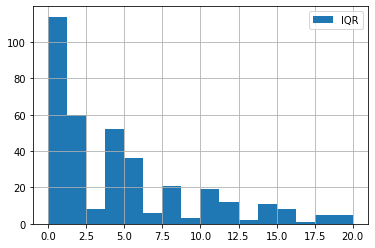

In [52]:
dist_iqr('absences')

Удалим все то, что выходит за границы выбросов.

In [53]:
students = students.drop(students[students.absences >= 20].index)

Далее проведем анализ номинативных переменных

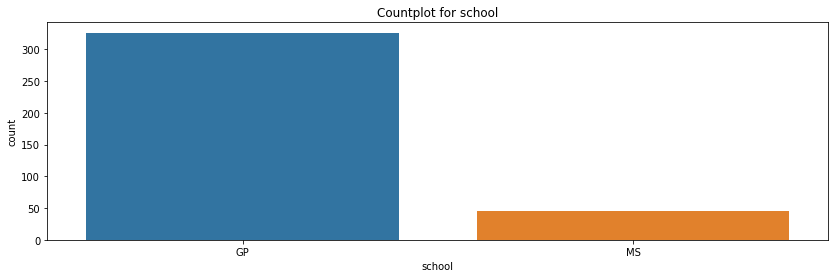

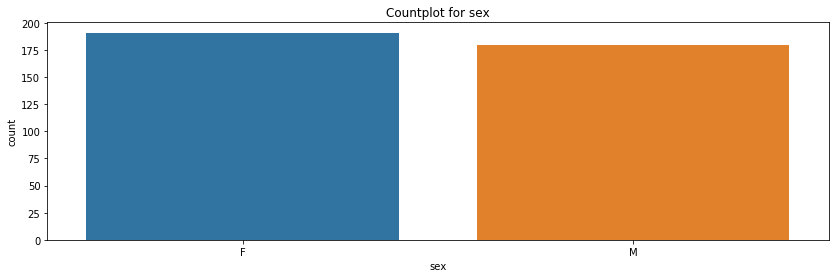

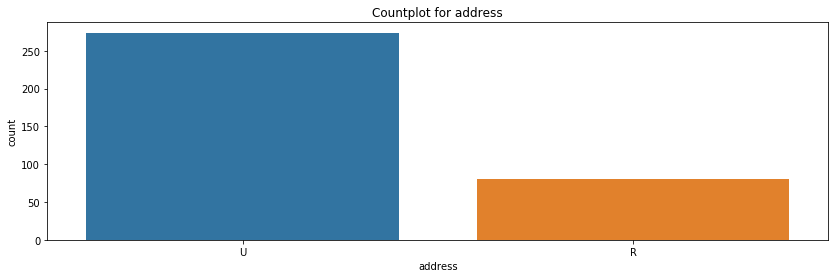

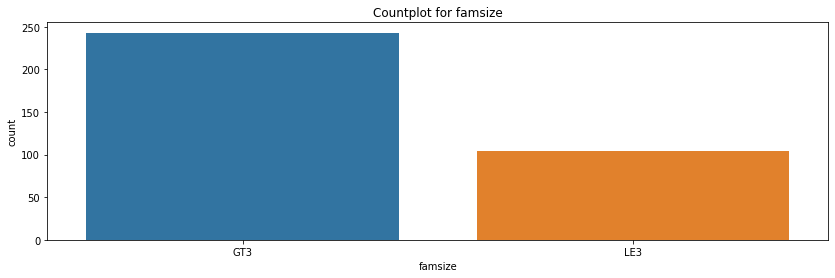

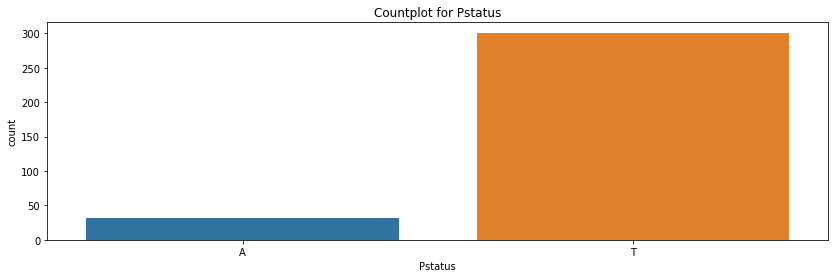

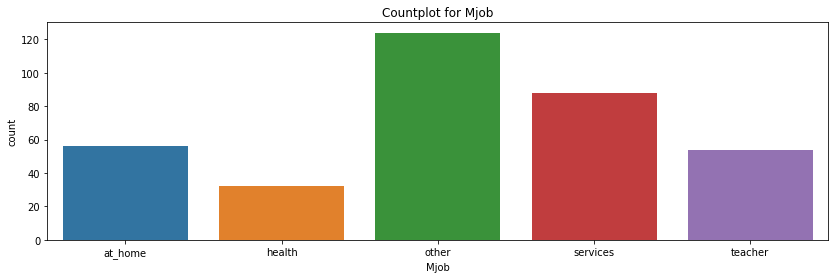

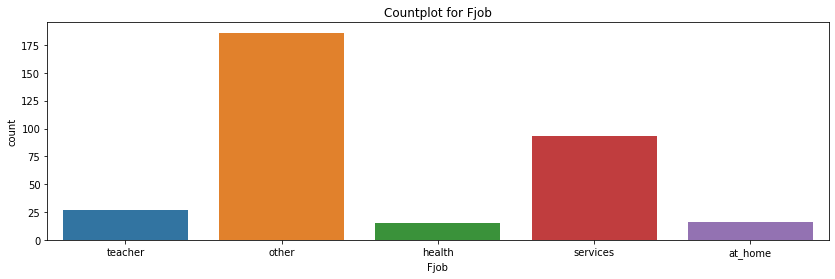

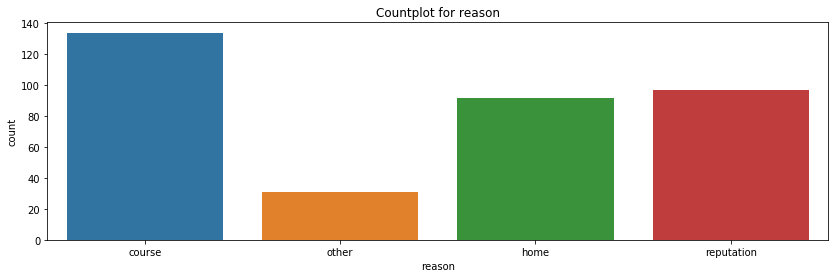

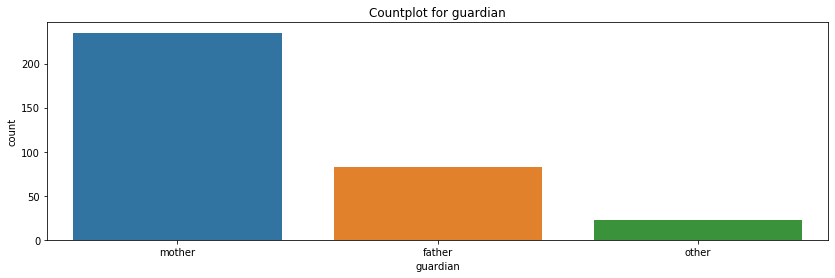

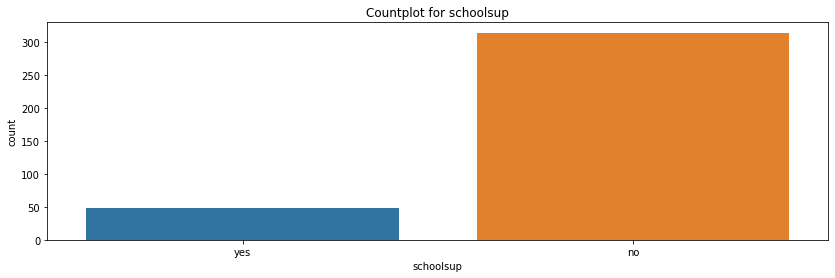

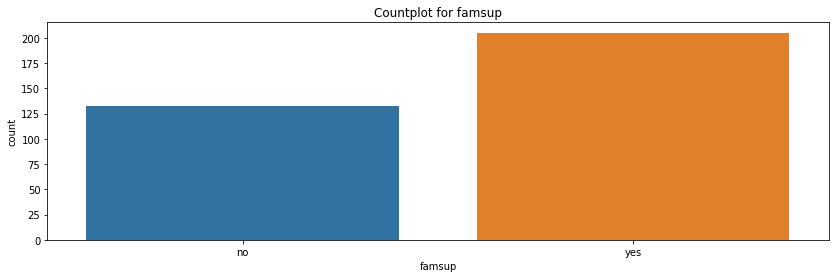

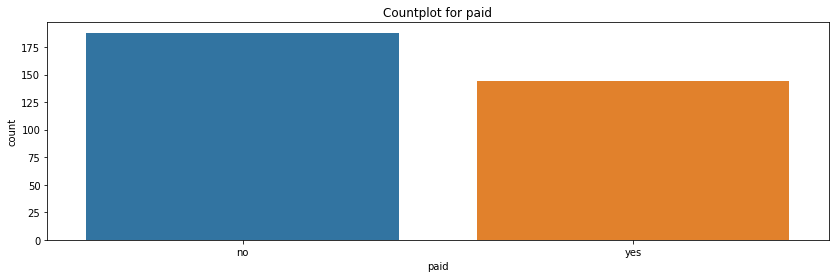

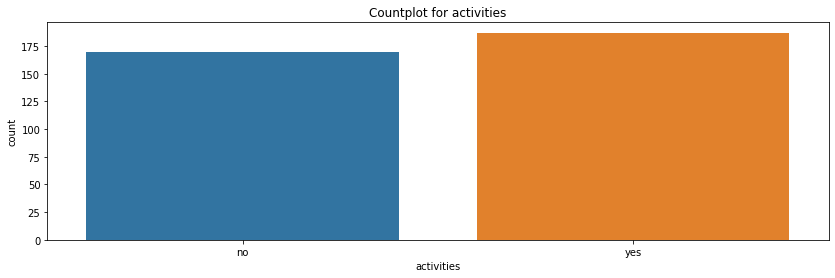

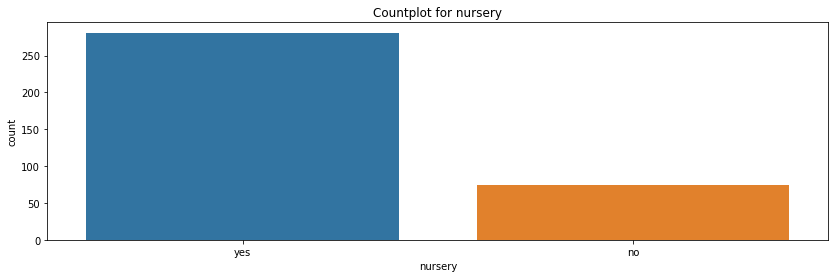

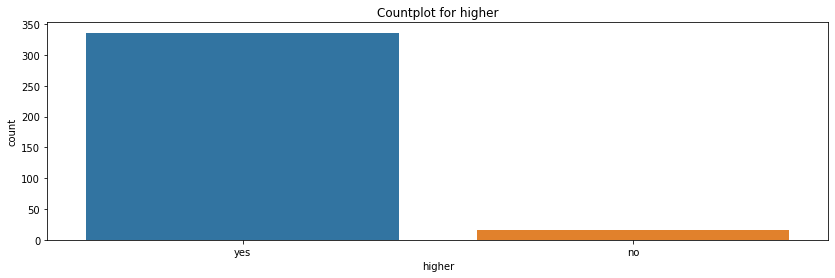

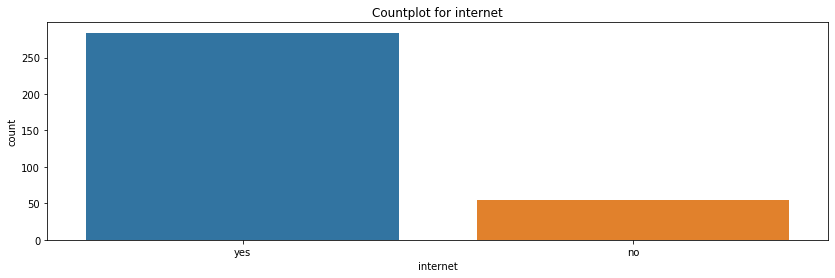

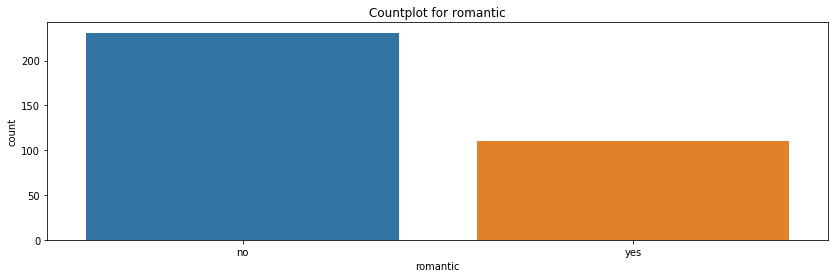

In [54]:
# Посмотрим распределение номинативных переменных
for col in object_col:
    get_countplot(col)

Во-первых, у большинства (13 из 17) номинативных переменных всего 2 уникальных значения.
Рассмотрим каждую переменную отдельно.

Большинство учеников:
 1. Посещали школу MS.
 2. Живут с родителями.
 3. С опекуном - матерью.
 4. Не получали дополнительную образовательную поддержку.
 5. Посещали детский сад.
 6. Хотят получить высшее образование.
 7. Имеют доступ к интернету. 

По остальным признакам ничего примечательного, распределены более-менее равномерно.

Далее оценим степень влияния на целевую переменную номинативных переменных. 

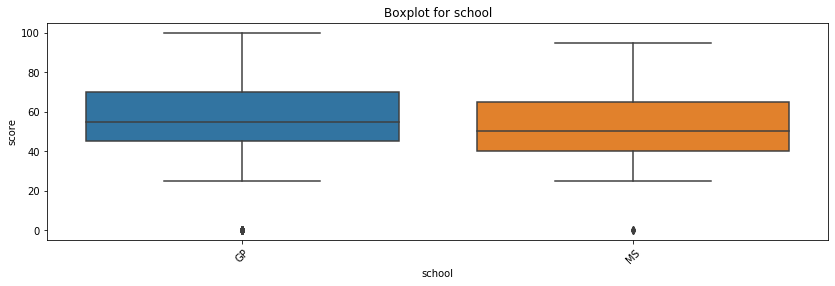

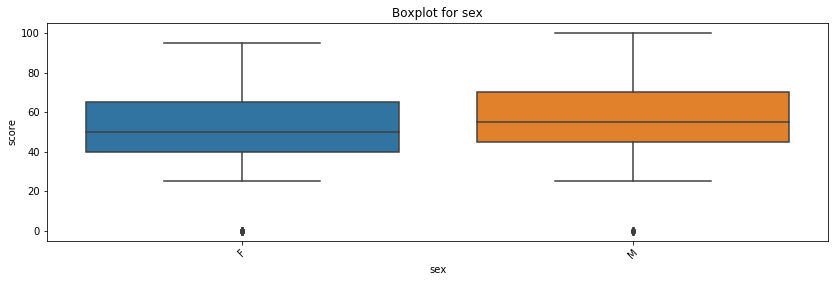

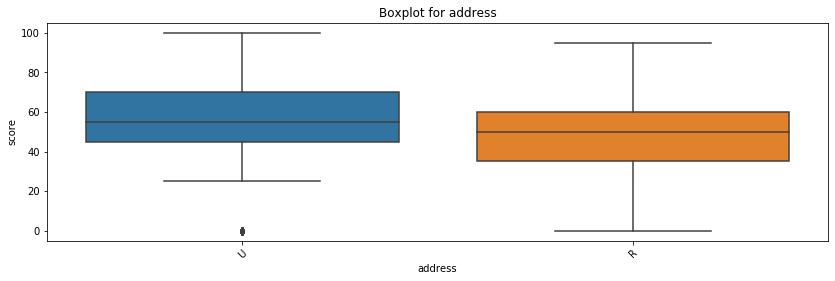

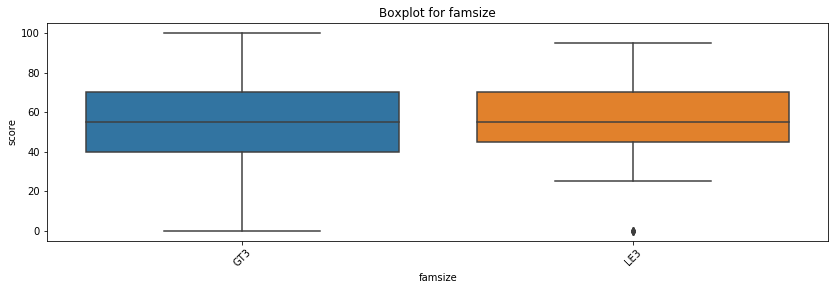

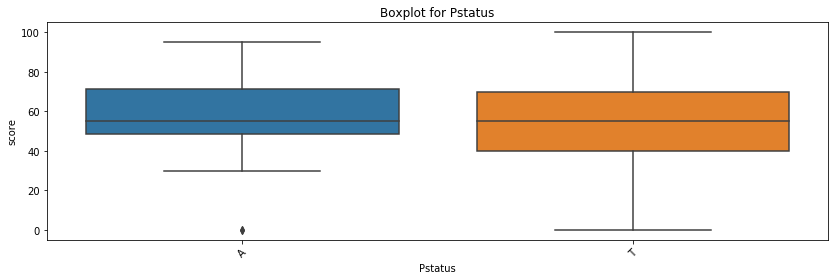

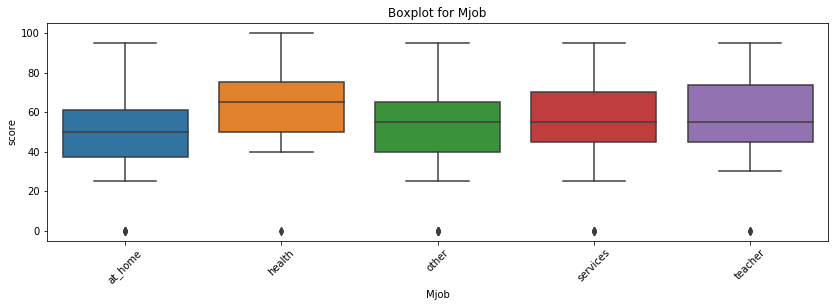

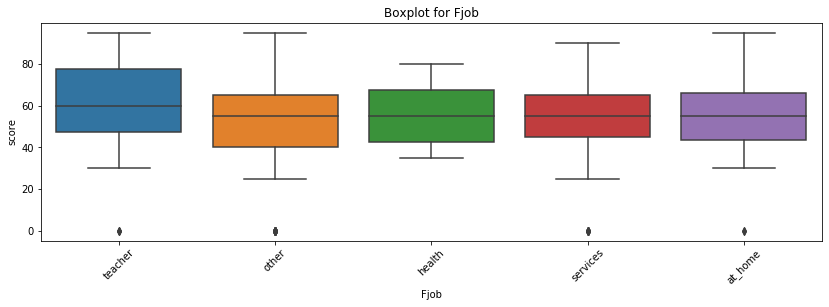

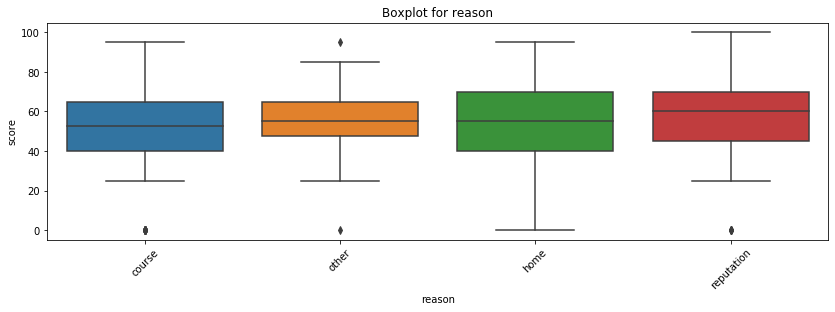

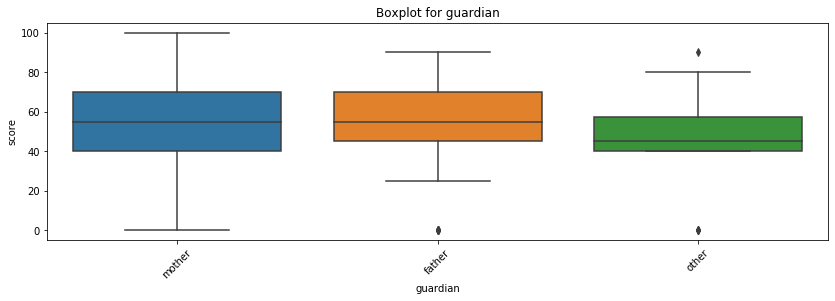

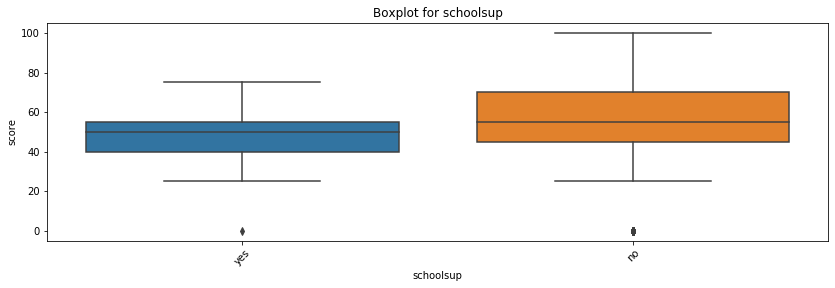

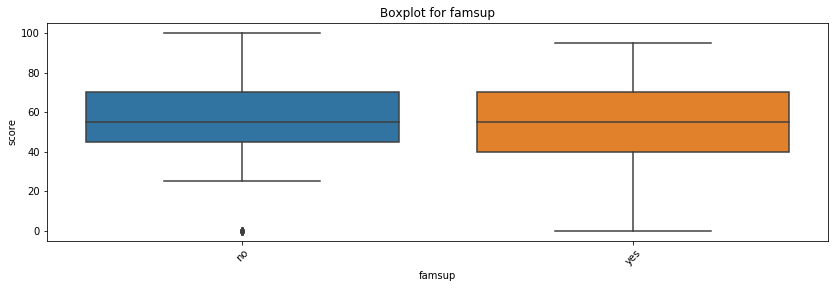

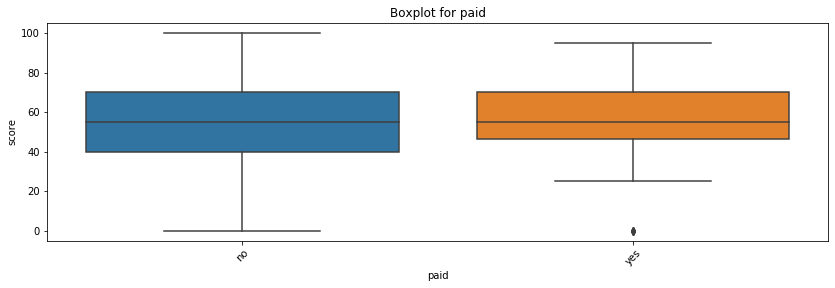

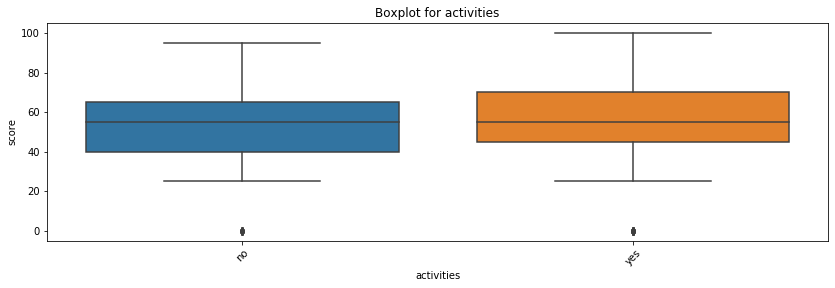

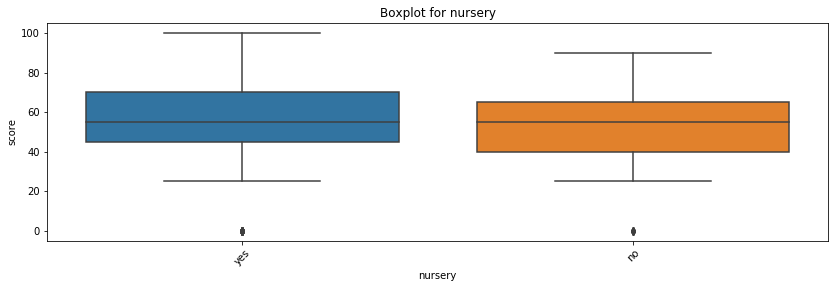

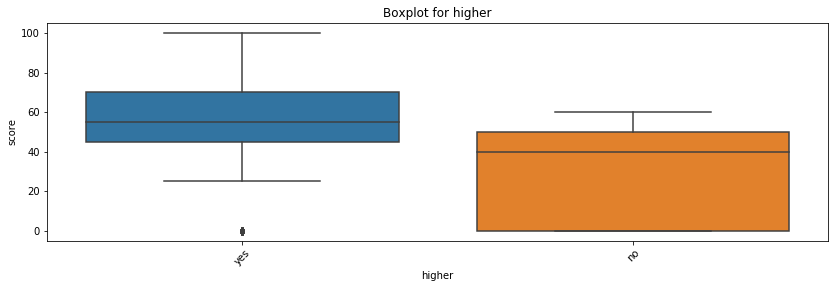

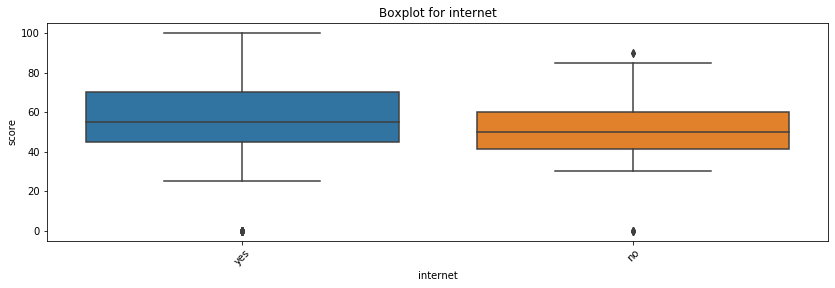

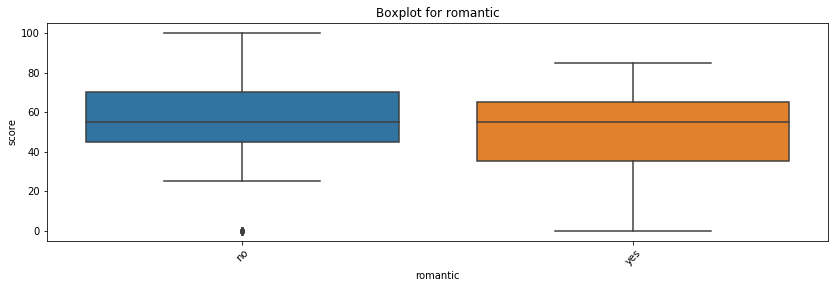

In [55]:
for col in object_col:
    get_boxplot(col)

По данным графикам можно предположить, что влияние на целевую переменную оказывают такие показатели, как Mjob, Fjob, schoolsup, higher. Но в последних двух показателях был заметный перекос в сторону одного из значений, поэтому использовать их в построении модели чревато переобучением. 

Далее попробуем определить статистическую значимость показателей. Я пока не сильна в статистике и проверке гипотез, поэтому недолго думая беру формулу из предыдущего EDA про шоколадные батончики. 

In [56]:
for col in object_col:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки Mjob


Проверка на статистическую значимость показала, что значимым является только номинативный показатель Mjob. Таким образом, из номинативных переменных можно оставить только переменную Mjob. 

In [58]:
for col in object_col:
    if col != 'Mjob':
        students.drop(col, axis=1, inplace=True)

In [60]:
# Заменим пропуски в колонке Mjob значениями others
students = students.fillna({'Mjob':'others'})

Далее проведем корреляционный анализ для числовых переменных

In [62]:
correlation = students.corr()

                          age      Medu      Fedu  traveltime  studytime  \
age                  1.000000 -0.190099 -0.158934    0.095230   0.004573   
Medu                -0.190099  1.000000  0.603817   -0.160493   0.095065   
Fedu                -0.158934  0.603817  1.000000   -0.133832  -0.000040   
traveltime           0.095230 -0.160493 -0.133832    1.000000  -0.097253   
studytime            0.004573  0.095065 -0.000040   -0.097253   1.000000   
failures             0.185474 -0.260374 -0.277862    0.069816  -0.160201   
studytime, granular -0.004544 -0.095827  0.000091    0.098478  -1.000000   
famrel               0.054019 -0.020031 -0.027490   -0.021543   0.025202   
freetime             0.037423  0.038179 -0.006800    0.019729  -0.125439   
goout                0.135653  0.048037  0.033651    0.061315  -0.038326   
health              -0.031057 -0.039853  0.002556   -0.047596  -0.081596   
absences             0.108366  0.097667  0.001097   -0.065350  -0.055206   
score       

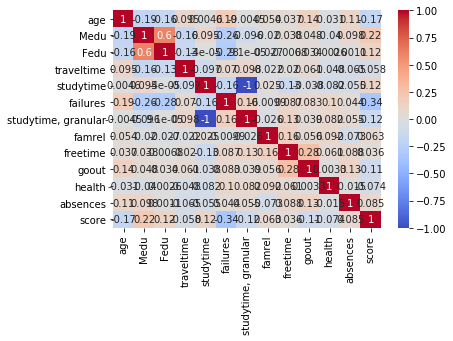

In [66]:
print(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Сразу можно выделить сильную обратную зависимость между переменными studytime и studytime, granular. 
Последнюю можно удалить.

In [67]:
students.drop('studytime, granular', axis=1, inplace=True)

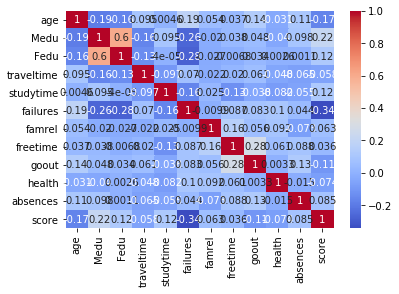

In [70]:
correlation = students.corr()
# print(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Следующая зависимость, котрую мы наблюдаем, это зависимость между переменными Fedu, Medu. Так как Medu сильнее влияет на score, удалим Fedu.

In [71]:
students.drop('Fedu', axis=1, inplace=True)

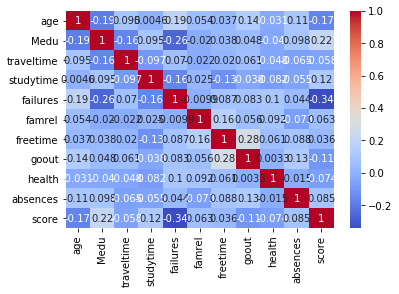

In [72]:
correlation = students.corr()
# print(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Если проанализировать окончательную матрицу корреляций, средм значимых переменных можно выделить age, Medu, studytime, failures, goout. 

In [73]:
for col in ['traveltime', 'famrel', 'freetime', 'health', 'absences']:
    students.drop(col, axis=1, inplace=True)

In [76]:
students.columns

Index(['age', 'Medu', 'Mjob', 'studytime', 'failures', 'goout', 'score'], dtype='object')

## Вывод

В ходе проведенного анализа я попрактиковалась в проверке качества данных и их очистке и обработке, сформулировала гипотезы касаемо влияния переменных на целевую, проверила эти гипотезы с использованием инструментов математической статистики. 

Сами данные были очищены от выбросов (в переменных age, Fedu, famrel, absences), заполнены значения Null значениями медианы для данного признака. Медиана выбиралась, так как средняя не являлась целым числом, а все числовые переменные дискретны.

В качестве входных параметров будущей модели были выбраны age, Medu, Mjob, studytime, failures, goout. Но на самом деле, при построении реальной модели, лучше убирать переменные постепенно и проверять, как при этом меняется качество модели. 